# Changes:
Reload saved model and troubleshoot low score

In [51]:
import zipfile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt

% matplotlib inline

In [509]:
def rle_encoder2d(x):
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()
    s = pd.Series(x.clip(0,1).flatten('F'))
    s.index = s.index+1
    df = s.to_frame('pred').assign(zero_cumcnt=s.eq(0).cumsum())
    df = df.loc[df.pred.gt(0)]
    df_rle = df.reset_index().groupby('zero_cumcnt').agg({'index': min, 'pred': sum}).astype(int).astype(str)
    rle = ' '.join((df_rle['index'] + ' '+df_rle['pred']).tolist())
    
    return rle

In [510]:
def rle_encoder3d(x):   
    return np.r_[[rle_encoder2d(e) for e in x]]

In [7]:
def load_img_to_df(img_path, normalize=False, mean_img=None, img_dtype=np.float):
    images = []
    for filename in glob.glob(f'{img_path}/*.png'): #assuming gif
        img_id = filename.split('\\')[-1].split('.')[0]
        img = np.array(imageio.imread(filename), dtype=img_dtype)
        if normalize:
            img -= mean_img[:,:,None]
        images.append([img_id, img])
    return pd.DataFrame(images, columns=['img_id', 'img']).set_index('img_id')

In [8]:
def load_img_to_np(img_path):
    images = []
    for filename in glob.glob(f'{img_path}/*.png'): #assuming gif
        img_id = filename.split('\\')[-1].split('.')[0]
        images.append(np.array(imageio.imread(filename), dtype=np.uint8))
    return np.r_[images]

In [2]:
df_depth = pd.read_csv('./data/train.csv')

In [654]:
img = np.array(imageio.imread('./data/train/images/0d8ed16206.png'), dtype=np.uint8)

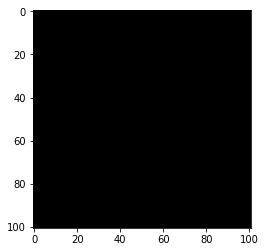

In [655]:
plt.imshow(img)

In [9]:
np_train = load_img_to_np('./data/train/images')

In [10]:
mean_img = np_train[:,:,:,0].reshape(np_train.shape[0], -1).mean(0).reshape(101,101)

In [11]:
df_train = load_img_to_df('./data/train/images', normalize=True, mean_img=mean_img)

In [12]:
df_train['mask'] = load_img_to_df('./data/train/masks/', img_dtype=np.uint8)['img']

In [117]:
df_test = load_img_to_df('./data/test/images', normalize=True, mean_img=mean_img)

In [118]:
np_test = np.r_[df_test.img.tolist()]

In [119]:
np_test[:,:,:,1].mean()

-0.6330799240815169

In [120]:
np_test.shape

(18000, 101, 101, 3)

In [13]:
X_train, X_val, y_train, y_val = (
    train_test_split(df_train, df_train['mask'], 
                     test_size=0.20, 
                     random_state=42)
)

In [14]:
X_train = np.r_[X_train.img.tolist()]

In [15]:
X_val = np.r_[X_val.img.tolist()]

In [16]:
y_train = np.r_[y_train.tolist()]

In [17]:
y_val = np.r_[y_val.tolist()]

In [18]:
def format_train_data(X):
    X = np.moveaxis(X, -1,1)
    X = np.pad(X, [(0,0),(0,0),(0, 1), (0, 1)], mode='constant')
    return torch.from_numpy(X).float()

In [19]:
def get_train_batch(X_train, y_train, batch_size):
    batch_ids = np.random.choice(len(X_train), batch_size, replace=False)
    X_train_batch = X_train[batch_ids]
    X_train_batch = np.moveaxis(X_train_batch, -1,1)
    X_train_batch = np.pad(X_train_batch, [(0,0),(0,0),(0, 1), (0, 1)], mode='constant')
    y_train_batch = np.clip(y_train[batch_ids],0,1)
    
    return (torch.from_numpy(X_train_batch).float(), torch.from_numpy(y_train_batch).float())

In [305]:
def calc_iou(a, b):
    thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
    
    a = np.clip(a, 0, 1)
    b = np.clip(b, 0, 1)
    u = np.sum(np.clip(a+b, 0, 1), (1,2)).astype(np.float)
    i = np.sum(np.where((a+b)==2, 1, 0), (1,2)).astype(np.float)
    #u[u==0]=np.nan
    #iou = np.nan_to_num(i/u)
    iou = np.where(i==u, 1, np.where(u==0, 0, i/u))
    iou_mean = (iou[:,None]>thresh).mean(1).mean()
    
    return iou_mean

In [20]:
class SaltNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(3,64,3, padding=10),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,128,3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,256,3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 2, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        out = self.seq(X)
        return out[:,:,:-1,:-1].squeeze()

In [21]:
saltnet = SaltNet()

In [22]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)

In [23]:
import time
import math

In [24]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [25]:
start = time.time()

In [492]:
for i in range(2500):
    X_batch, y_batch = get_train_batch(X_train, y_train, batch_size=64)
    y_pred = saltnet(X_batch)
    optimizer.zero_grad()
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    
    if i % 10 == 0:
        print(f'Loss is {loss} at iter {i}, Time: {timeSince(start)}')

Loss is 0.7075795531272888 at iter 0, Time: 0m 7s
Loss is 0.6087774634361267 at iter 10, Time: 1m 32s
Loss is 0.5375742316246033 at iter 20, Time: 2m 39s
Loss is 0.5098478198051453 at iter 30, Time: 3m 46s
Loss is 0.4907909035682678 at iter 40, Time: 4m 55s
Loss is 0.5025970935821533 at iter 50, Time: 6m 5s
Loss is 0.5129656791687012 at iter 60, Time: 7m 17s
Loss is 0.3500281870365143 at iter 70, Time: 8m 35s
Loss is 0.46371912956237793 at iter 80, Time: 9m 55s
Loss is 0.38141101598739624 at iter 90, Time: 11m 10s
Loss is 0.45511162281036377 at iter 100, Time: 12m 23s
Loss is 0.4406242072582245 at iter 110, Time: 13m 34s
Loss is 0.27835792303085327 at iter 120, Time: 14m 45s
Loss is 0.2957882881164551 at iter 130, Time: 15m 56s
Loss is 0.39439597725868225 at iter 140, Time: 18m 58s
Loss is 0.3745402991771698 at iter 150, Time: 22m 18s
Loss is 0.28691571950912476 at iter 160, Time: 25m 34s
Loss is 0.29820430278778076 at iter 170, Time: 28m 50s
Loss is 0.3296818435192108 at iter 180, Tim

KeyboardInterrupt: 

In [495]:
state = {'epoch': i + 1, 'state_dict': saltnet.state_dict(),
             'optimizer': optimizer.state_dict() }
torch.save(state, 'saltnet_v1_20180808_0837.cpt')

## Load checkpoint

In [26]:
state = torch.load('saltnet_v1_20180808_0837.cpt')

In [27]:
saltnet.load_state_dict(state['state_dict'])

In [28]:
X_val_torch = format_train_data(X_val)

In [31]:
saltnet.eval()

SaltNet(
  (seq): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(10, 10))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ConvTranspose

In [32]:
saltnet.training

False

In [33]:
with torch.no_grad():
    y_val_pred = saltnet(X_val_torch)

y_val_pred = y_val_pred.ge(0.5)

In [90]:
X_train_small_torch = format_train_data(X_train[:800])

with torch.no_grad():
    y_train_small_pred_raw = saltnet(X_train_small_torch)

y_train_small_pred = y_train_small_pred_raw.ge(0.5)

In [126]:
X_test_small_torch = format_train_data(np_test[:800])

with torch.no_grad():
    y_test_small_pred_raw = saltnet(X_test_small_torch)

y_test_small_pred = y_test_small_pred_raw.ge(0.5)

In [82]:
def plot_img_mask_pred(image, mask, pred):
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[2].imshow(pred)
    axarr[0].grid()
    axarr[1].grid()
    axarr[2].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')
    axarr[2].set_title('Predicted Mask')

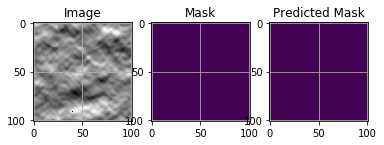

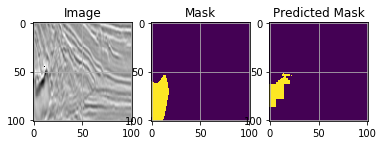

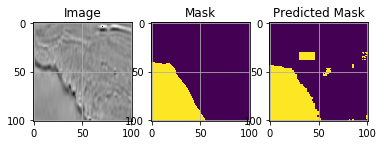

In [114]:
for i in range(3):
    rand_id = np.random.choice(len(X_val))
    val_img = X_val[rand_id] + mean_img[:,:,None]
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred[rand_id].detach().numpy()
    plot_img_mask_pred(val_img, val_mask, val_mask_pred)

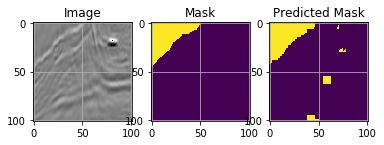

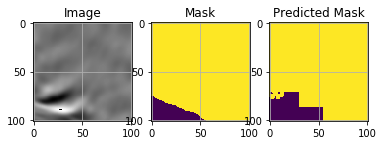

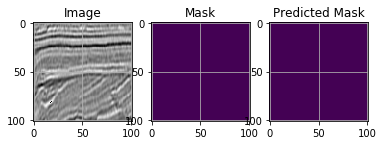

In [116]:
for i in range(3):
    rand_id = np.random.choice(len(X_train_small_torch))
    #print(rand_id)
    img = X_train[rand_id] + mean_img[:,:,None]
    mask = y_train[rand_id]
    mask_pred = y_train_small_pred[rand_id].detach().numpy()
    plot_img_mask_pred(img, mask, mask_pred)

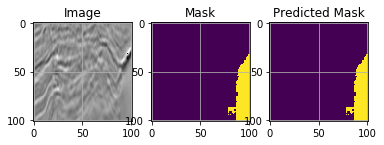

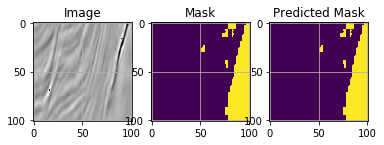

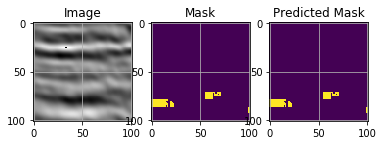

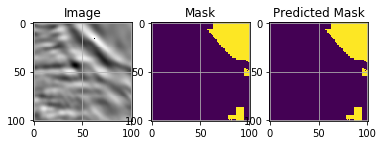

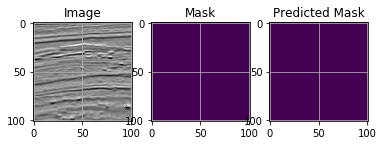

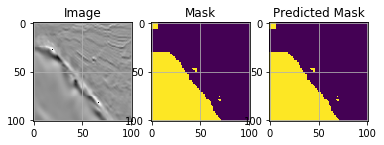

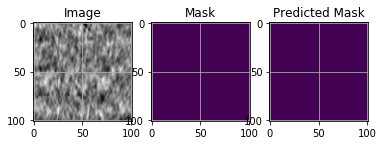

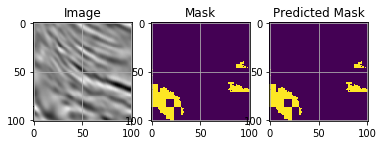

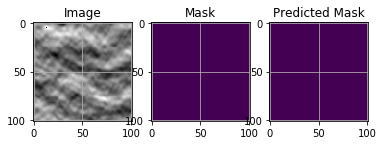

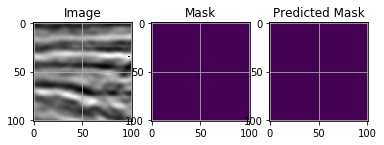

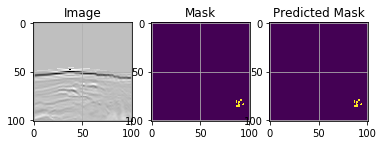

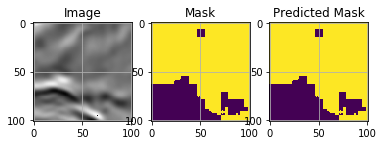

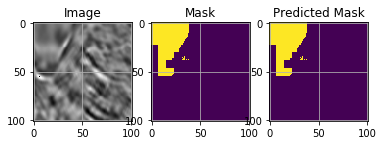

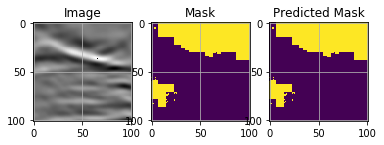

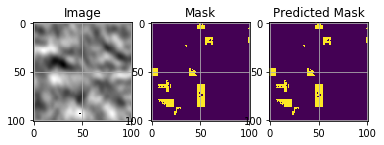

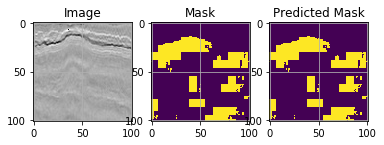

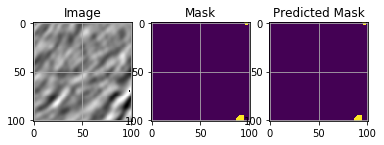

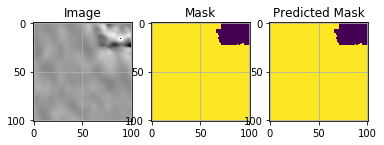

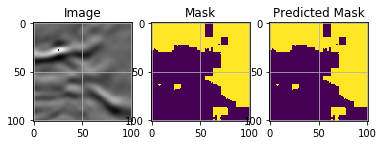

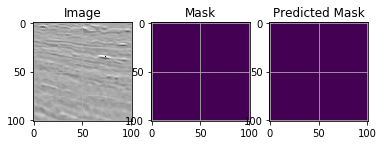

In [130]:
for i in range(20):
    rand_id = np.random.choice(len(X_test_small_torch))
    #print(rand_id)
    img = np_test[rand_id] + mean_img[:,:,None]
    #mask = y_train[rand_id]
    mask_pred = y_test_small_pred[rand_id].detach().numpy()
    plot_img_mask_pred(img, mask_pred, mask_pred)

In [ ]:
X_test_small_torch = format_train_data(np_test[:800])

with torch.no_grad():
    y_test_small_pred_raw = saltnet(X_test_small_torch)

y_test_small_pred = y_test_small_pred_raw.ge(0.5)

In [137]:
18000/36

500.0

In [138]:
y_test_pred_raw = []

In [139]:
len(y_test_pred_raw)

0

In [140]:
np_test.shape

(18000, 101, 101, 3)

In [141]:
for x in np.split(np_test, 36):
    with torch.no_grad():
        y_test_pred_raw.append(saltnet(format_train_data(x)))

In [142]:
y_test_pred_raw = torch.cat(y_test_pred_raw)

In [143]:
y_test_pred = y_test_pred_raw.ge(0.5)

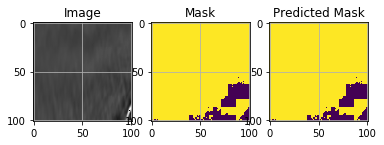

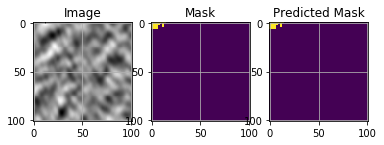

In [724]:
for i in range(2):
    rand_id = np.random.choice(len(np_test))
    #print(rand_id)
    img = np_test[rand_id] + mean_img[:,:,None]
    #mask = y_train[rand_id]
    mask_pred = y_test_pred[rand_id].detach().numpy()
    plot_img_mask_pred(img, mask_pred, mask_pred)

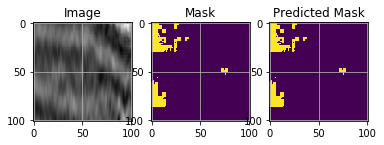

In [330]:
plot_img_mask_pred(np_test[2]+mean_img[:,:,None], y_test_pred[2].detach().numpy(), y_test_pred[2].detach().numpy())

In [332]:
y_test_pred.detach().numpy()[2]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [429]:
x = y_test_pred.detach().numpy()[2]

In [430]:
x.shape

(101, 101)

In [340]:
x = np.random.randint(0,2,25).reshape(5,5)

In [642]:
(np_test.mean((1,2,3))==0).sum()

0

In [648]:
X_train.shape

(3200, 101, 101, 3)

In [649]:
mean_img.shape

(101, 101)

In [652]:
X_train+mean_img[None,:,:,None]

array([[[[109., 109., 109.],
         [108., 108., 108.],
         [104., 104., 104.],
         ...,
         [105., 105., 105.],
         [104., 104., 104.],
         [102., 102., 102.]],

        [[109., 109., 109.],
         [108., 108., 108.],
         [105., 105., 105.],
         ...,
         [102., 102., 102.],
         [102., 102., 102.],
         [101., 101., 101.]],

        [[109., 109., 109.],
         [109., 109., 109.],
         [105., 105., 105.],
         ...,
         [110., 110., 110.],
         [109., 109., 109.],
         [108., 108., 108.]],

        ...,

        [[ 89.,  89.,  89.],
         [ 89.,  89.,  89.],
         [ 89.,  89.,  89.],
         ...,
         [112., 112., 112.],
         [111., 111., 111.],
         [107., 107., 107.]],

        [[ 91.,  91.,  91.],
         [ 91.,  91.,  91.],
         [ 89.,  89.,  89.],
         ...,
         [119., 119., 119.],
         [119., 119., 119.],
         [116., 116., 116.]],

        [[ 93.,  93.,  93.],
       

In [662]:
((np_test+mean_img[None,:,:,None]).mean((1,2,3))==0).sum()

430

(array([ 431.,   29.,  449., 2734., 6968., 5806., 1369.,  189.,   13.,
          12.]), array([  0.        ,  25.47772767,  50.95545535,  76.43318302,
        101.9109107 , 127.38863837, 152.86636604, 178.34409372,
        203.82182139, 229.29954906, 254.77727674]), <a list of 10 Patch objects>)

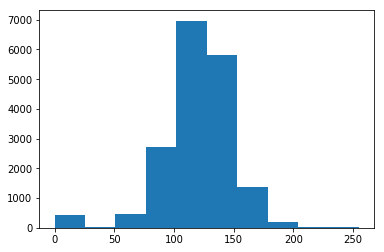

In [663]:
plt.hist((np_test+mean_img[None,:,:,None]).mean((1,2,3)))

In [664]:
((X_train+mean_img[None,:,:,None]).mean((1,2,3))==0).sum()

63

In [705]:
((X_train+mean_img[None,:,:,None]).mean((1,2,3))<50).sum()

66

In [706]:
y_train_black = y_train[((X_train+mean_img[None,:,:,None]).mean((1,2,3))<50)]

In [707]:
y_train_black.shape

(66, 101, 101)

In [685]:
import torchvision

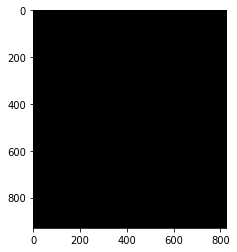

In [708]:
plt.imshow(torchvision.utils.make_grid(torch.from_numpy(y_train_black).unsqueeze(1)).permute(1, 2, 0))

In [709]:
BLACK_IMG_MEAN = 50
ZERO_MASK_CUTOFF = 120

In [ ]:
y_test_pred = y_test_pred.detach().numpy()

In [722]:
# Set predictions to all 0 for black images
blak_img_mask = ((np_test+mean_img[None,:,:,None]).mean((1,2,3))<BLACK_IMG_MEAN)
y_test_pred[blak_img_mask]=0

In [733]:
y_test_pred.sum()

39318462

In [740]:
# set all predictions to 0 if the number of positive predictions is less than ZERO_MASK_CUTOFF
y_test_pred = np.r_[[e if e.sum()>ZERO_MASK_CUTOFF else np.zeros_like(e) for e in y_test_pred]]

In [744]:
#y_test_pred_rle = rle_encoder3d(y_test_pred.detach().numpy())
y_test_pred_rle = rle_encoder3d(y_test_pred)

In [745]:
df_test_rle = pd.DataFrame(index=df_test.index, data=y_test_pred_rle).reset_index()

In [746]:
df_test_rle.columns = ['id', 'rle_mask']

In [747]:
df_test_rle.to_csv('submission_20180810_02.csv', index=False)

In [566]:
y_train_small_pred.shape

torch.Size([800, 101, 101])

In [568]:
calc_iou(y_train_small_pred.detach().numpy(), y_train[:800])

c:\program files (x86)\python\anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


0.48025000000000007

In [570]:
calc_iou(y_val_pred.detach().numpy(), y_val)

c:\program files (x86)\python\anaconda\envs\py36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


0.477625

In [757]:
y_val_pred = y_val_pred.detach().numpy()

In [760]:
# Set predictions to all 0 for black images
black_img_mask = ((X_val+mean_img[None,:,:,None]).mean((1,2,3))<BLACK_IMG_MEAN)
y_val_pred[black_img_mask]=0

In [769]:
# set all predictions to 0 if the number of positive predictions is less than ZERO_MASK_CUTOFF
y_val_pred = np.r_[[e if e.sum()>ZERO_MASK_CUTOFF else np.zeros_like(e) for e in y_val_pred]]

In [766]:
sum(black_img_mask)

17

In [765]:
y_val_pred.sum()

1678083

In [770]:
y_val_pred.sum()

1672538

In [1]:
calc_iou(y_val_pred, y_val)

NameError: name 'calc_iou' is not defined

In [575]:
y_train.clip(0,1).sum() / y_train.size

0.24900631678266835

In [585]:
(y_val.clip(0,1).mean((1,2))==0).sum()

326

In [621]:
(y_val_pred.detach().numpy().sum((1,2))<120).sum()

317

In [622]:
(y_train_small_pred.detach().numpy().sum((1,2))<120).sum()

292

In [612]:
(y_train[:800].sum((1,2))==0).sum()

310

In [597]:
df_y_train_mask_sum = (
    pd.Series((y_train.clip(0,1).sum((1,2))))
    .to_frame('mask_sum')
    .assign(mask_sum=lambda x: x.mask_sum.round(-1))
)
    

In [600]:
df_y_train_mask_sum.shape

(3200, 1)

In [602]:
326/800

0.4075

In [601]:
1260/3200

0.39375

In [603]:
df_y_train_mask_sum.groupby('mask_sum').mask_sum.count().head()

mask_sum
0     1260
10      19
20      21
30      13
40       8
Name: mask_sum, dtype: int64